In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "M_450_20k"
    npy_file_name_aniso = f"p_ori_fully5d_fzab_aveE_f1.0_t0.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_aniso_energy = f"p_ori_fully5d_fzab_aveE_f1.0_t0.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The M_450_20k data size is: (76, 450, 450, 450)
READING DATA DONE
The M_450_20k energy data size is: (76, 450, 450, 450)
READING ENERGY DATA DONE


In [3]:
step_1000grains = 40
len(np.unique(npy_file_aniso[40,:]))

1014

In [4]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    from collections import defaultdict
    step_num=51
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/3D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/3D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"].item()
            GB_infomation_dict_list.append(GB_infomation_dict)
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name,allow_pickle=True)
                curvature_matrix = npz_file_curvature["curvature_matrix"].item()
                curvature_matrix_list.append(curvature_matrix)
            else:
                curvature_matrix = post_processing.IO_curvature(current_microstructure)
                # save curvature information
                np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Create shifted arrays for all 6 directions at once
            neighbors = np.stack([
                np.roll(current_microstructure, -1, axis=0),
                np.roll(current_microstructure, 1, axis=0),
                np.roll(current_microstructure, -1, axis=1),
                np.roll(current_microstructure, 1, axis=1),
                np.roll(current_microstructure, -1, axis=2),
                np.roll(current_microstructure, 1, axis=2)
            ])
            neighbor_array = neighbors.reshape(6, -1).T
            
            # Find boundary voxels efficiently
            boundary_mask = (neighbors != current_microstructure[None,...]).any(axis=0)
            boundary_coords = np.argwhere(boundary_mask)
            
            GB_infomation_dict = defaultdict(list)
            gb_points_by_pair = defaultdict(list)
            pair_id_pair_dict = defaultdict(list)
            
            for idx, (i, j, k) in enumerate(boundary_coords):
                flat_idx = i * size_y * size_z + j * size_z + k
                neighbor_vals = neighbor_array[flat_idx]
                central_site = current_microstructure[i,j,k]
                unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])
                
                if len(unique_neighbors) == 1:  # Single boundary point
                    neighbor = unique_neighbors[0]
                    pair_id = post_processing.get_line(central_site, neighbor)
                    pair_id_pair = sorted([central_site, neighbor])
                        
                    # Collect points for batch processing
                    gb_points_by_pair[pair_id].append([i,j,k])
                    if pair_id not in pair_id_pair_dict:
                        pair_id_pair_dict[pair_id].append(pair_id_pair)
            print("completed GB voxel collection")
            
            # Process each pair_id's points in batch
            for pair_id, points in gb_points_by_pair.items():
                # calculate or extract curvature
                if pair_id not in curvature_matrix: continue
                pair_id_pair = pair_id_pair_dict[pair_id][0]
                
                area = len(points)
                pos_ave = np.sum(points, axis=0) / area
                
                GB_infomation_dict[pair_id] = np.array([area, pos_ave[0],pos_ave[1],pos_ave[2],-curvature_matrix[pair_id][3],area,pair_id_pair[0],pair_id_pair[1]])
            print("Completed GB information collection")    
            
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            

100%|██████████| 51/51 [00:07<00:00,  7.26it/s]


In [5]:
    # GB Energy information
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/3D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                            current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                            current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                        GBenergy_information_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    # remove the TJs and QJs
                    # if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    # calculate or extract GB energy
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 51/51 [00:08<00:00,  5.76it/s]


In [6]:
    from numba import njit, prange
    import multiprocessing as mp
    
    @njit(parallel=True)
    def compute_dV(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2)
    
    @njit(parallel=True)
    def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)
    
    def compute_necessary_info(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV = compute_dV(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < -0.0001
        }
        
        return result
    
    def compute_necessary_info_split(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "dV_direction1": dV_direction1,
            "dV_direction2": dV_direction2,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < -0.0001
        }
        
        return result
    
    # if __name__ == '__main__':
    time_interval = 2
    curvature_limit = 0.00794
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    GB_list_area_list = []
    GB_list_dV_direction1 = []
    GB_list_dV_direction2 = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    dV_dict = []
    for time_step in range(3,step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        GB_list_dV_direction1_tmp = []
        GB_list_dV_direction2_tmp = []
        key_set = set()

        # MP
        # remove disappeared GBs and low area GBs and remove low curvature
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        tmp_GBenergy_information_dict_for_mp = {}
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < 100 or 
                GB_infomation_dict_list[time_step+1].get(key) is None or 
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit): 
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
            tmp_GBenergy_information_dict_for_mp[key] = GBenergy_information_dict_list[time_step][key]
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        # run key
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp=dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]
            else:
                result = compute_necessary_info_split(key,time_interval,tmp_GB_infomation_dict_for_mp[key],tmp_GBenergy_information_dict_for_mp[key],npy_file_aniso[time_step],npy_file_aniso[time_step+1])
                dV_dict_tmp[key] = result
            
            # Store these results remove ways-area,lowCurvature
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])
            
            # calculate GB area and store it
            current_GB_area = 0.5*tmp_GB_infomation_dict_for_mp[key][0]
            GB_list_area_list_tmp.append(current_GB_area)


            # keep anti-curvature GB info
            if result["is_anti_curvature"]: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        if not os.path.exists(data_file_folder + dV_dict_file_name):
            np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)

        # keep all GBs after ways-area,lowCurvature
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)
        GB_list_dV_direction1.append(GB_list_dV_direction1_tmp)
        GB_list_dV_direction2.append(GB_list_dV_direction2_tmp)

        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        # # filter the anti-curvature GB with 11111
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]&GB_filter_kernel[1]&GB_filter_kernel[3]&GB_filter_kernel[4]&GB_filter_kernel[2])
        # # filter the anti-curvature GB with 00100
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 01100
        # filtered_set1 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 00110
        # filtered_set2 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[4])
        # filtered_set = filtered_set0|filtered_set1|filtered_set2
        # # filter the anti-curvature GB with 010
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[1]|GB_filter_kernel[3])
        
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")


    # filter the GBs in GB_id_focus without anti-curvature behavior after 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])


key num start with 117710
key num end with 51454


100%|██████████| 51454/51454 [00:00<00:00, 303610.62it/s]


finish 3 with num of GBs 51454, and collected num of GBs 16486
key num start with 102689
key num end with 45633


100%|██████████| 45633/45633 [00:00<00:00, 613005.39it/s]


finish 4 with num of GBs 45633, and collected num of GBs 26731
key num start with 89164
key num end with 40506


100%|██████████| 40506/40506 [00:00<00:00, 558312.45it/s]


finish 5 with num of GBs 40506, and collected num of GBs 33700
key num start with 77493
key num end with 35761


100%|██████████| 35761/35761 [00:00<00:00, 550809.20it/s]


finish 6 with num of GBs 35761, and collected num of GBs 38781
key num start with 67280
key num end with 31568


100%|██████████| 31568/31568 [00:00<00:00, 604104.39it/s]


finish 7 with num of GBs 31568, and collected num of GBs 42341
key num start with 58409
key num end with 27916


100%|██████████| 27916/27916 [00:00<00:00, 550014.52it/s]


finish 8 with num of GBs 27916, and collected num of GBs 45230
key num start with 51197
key num end with 25102


100%|██████████| 25102/25102 [00:00<00:00, 559053.45it/s]


finish 9 with num of GBs 25102, and collected num of GBs 47532
key num start with 45455
key num end with 22635


100%|██████████| 22635/22635 [00:00<00:00, 558768.21it/s]


finish 10 with num of GBs 22635, and collected num of GBs 49412
key num start with 40781
key num end with 20450


100%|██████████| 20450/20450 [00:00<00:00, 580225.10it/s]


finish 11 with num of GBs 20450, and collected num of GBs 51029
key num start with 36740
key num end with 18482


100%|██████████| 18482/18482 [00:00<00:00, 555433.86it/s]


finish 12 with num of GBs 18482, and collected num of GBs 52404
key num start with 33237
key num end with 16675


100%|██████████| 16675/16675 [00:00<00:00, 579861.70it/s]


finish 13 with num of GBs 16675, and collected num of GBs 53574
key num start with 30075
key num end with 15254


100%|██████████| 15254/15254 [00:00<00:00, 603436.07it/s]


finish 14 with num of GBs 15254, and collected num of GBs 54566
key num start with 27399
key num end with 14015


100%|██████████| 14015/14015 [00:00<00:00, 595809.60it/s]

finish 15 with num of GBs 14015, and collected num of GBs 55427


key num start with 25131
key num end with 12882


100%|██████████| 12882/12882 [00:00<00:00, 569179.00it/s]


finish 16 with num of GBs 12882, and collected num of GBs 56190
key num start with 23333
key num end with 12032


100%|██████████| 12032/12032 [00:00<00:00, 566987.60it/s]


finish 17 with num of GBs 12032, and collected num of GBs 56843
key num start with 21778
key num end with 11032


100%|██████████| 11032/11032 [00:00<00:00, 573903.72it/s]


finish 18 with num of GBs 11032, and collected num of GBs 57408
key num start with 20285
key num end with 10470


100%|██████████| 10470/10470 [00:00<00:00, 555638.88it/s]


finish 19 with num of GBs 10470, and collected num of GBs 57903
key num start with 19032
key num end with 9743


100%|██████████| 9743/9743 [00:00<00:00, 557375.56it/s]


finish 20 with num of GBs 9743, and collected num of GBs 58352
key num start with 17929
key num end with 9258


100%|██████████| 9258/9258 [00:00<00:00, 550925.28it/s]


finish 21 with num of GBs 9258, and collected num of GBs 58782
key num start with 16974
key num end with 8688


100%|██████████| 8688/8688 [00:00<00:00, 553254.58it/s]


finish 22 with num of GBs 8688, and collected num of GBs 59145
key num start with 16130
key num end with 8180


100%|██████████| 8180/8180 [00:00<00:00, 567303.92it/s]


finish 23 with num of GBs 8180, and collected num of GBs 59544
key num start with 15277
key num end with 7590


100%|██████████| 7590/7590 [00:00<00:00, 570556.44it/s]


finish 24 with num of GBs 7590, and collected num of GBs 59850
key num start with 14462
key num end with 7384


100%|██████████| 7384/7384 [00:00<00:00, 564819.37it/s]


finish 25 with num of GBs 7384, and collected num of GBs 60145
key num start with 13794
key num end with 6948


100%|██████████| 6948/6948 [00:00<00:00, 570182.43it/s]


finish 26 with num of GBs 6948, and collected num of GBs 60403
key num start with 13133
key num end with 6580


100%|██████████| 6580/6580 [00:00<00:00, 576458.36it/s]


finish 27 with num of GBs 6580, and collected num of GBs 60650
key num start with 12562
key num end with 6334


100%|██████████| 6334/6334 [00:00<00:00, 574813.31it/s]


finish 28 with num of GBs 6334, and collected num of GBs 60880
key num start with 11933
key num end with 5943


100%|██████████| 5943/5943 [00:00<00:00, 570575.88it/s]

finish 29 with num of GBs 5943, and collected num of GBs 61092
key num start with 11299


key num end with 5725


100%|██████████| 5725/5725 [00:00<00:00, 571003.03it/s]


finish 30 with num of GBs 5725, and collected num of GBs 61294
key num start with 10819
key num end with 5397


100%|██████████| 5397/5397 [00:00<00:00, 571156.83it/s]


finish 31 with num of GBs 5397, and collected num of GBs 61451
key num start with 10411
key num end with 5191


100%|██████████| 5191/5191 [00:00<00:00, 574536.42it/s]


finish 32 with num of GBs 5191, and collected num of GBs 61614
key num start with 9958
key num end with 4984


100%|██████████| 4984/4984 [00:00<00:00, 564541.61it/s]


finish 33 with num of GBs 4984, and collected num of GBs 61775
key num start with 9558
key num end with 4812


100%|██████████| 4812/4812 [00:00<00:00, 574997.60it/s]

finish 34 with num of GBs 4812, and collected num of GBs 61894
key num start with 9268
key num end with 4624



100%|██████████| 4624/4624 [00:00<00:00, 591655.33it/s]


finish 35 with num of GBs 4624, and collected num of GBs 62037
key num start with 8894
key num end with 4442


100%|██████████| 4442/4442 [00:00<00:00, 576921.36it/s]


finish 36 with num of GBs 4442, and collected num of GBs 62156
key num start with 8572
key num end with 4214


100%|██████████| 4214/4214 [00:00<00:00, 590912.94it/s]


finish 37 with num of GBs 4214, and collected num of GBs 62258
key num start with 8216
key num end with 4088


100%|██████████| 4088/4088 [00:00<00:00, 583346.88it/s]


finish 38 with num of GBs 4088, and collected num of GBs 62376
key num start with 7893
key num end with 3886


100%|██████████| 3886/3886 [00:00<00:00, 607177.22it/s]


finish 39 with num of GBs 3886, and collected num of GBs 62468
key num start with 7690
key num end with 3779


100%|██████████| 3779/3779 [00:00<00:00, 586938.52it/s]


finish 40 with num of GBs 3779, and collected num of GBs 62563
key num start with 7369
key num end with 3571


100%|██████████| 3571/3571 [00:00<00:00, 615284.05it/s]


finish 41 with num of GBs 3571, and collected num of GBs 62642
key num start with 7092
key num end with 3491


100%|██████████| 3491/3491 [00:00<00:00, 607943.34it/s]


finish 42 with num of GBs 3491, and collected num of GBs 62718
key num start with 6903
key num end with 3347


100%|██████████| 3347/3347 [00:00<00:00, 610946.80it/s]


finish 43 with num of GBs 3347, and collected num of GBs 62807
key num start with 6673
key num end with 3193


100%|██████████| 3193/3193 [00:00<00:00, 607200.43it/s]


finish 44 with num of GBs 3193, and collected num of GBs 62882
key num start with 6488
key num end with 3067


100%|██████████| 3067/3067 [00:00<00:00, 647502.41it/s]


finish 45 with num of GBs 3067, and collected num of GBs 62946
key num start with 6297
key num end with 3032


100%|██████████| 3032/3032 [00:00<00:00, 648502.28it/s]


finish 46 with num of GBs 3032, and collected num of GBs 63026
key num start with 6123
key num end with 2899


100%|██████████| 2899/2899 [00:00<00:00, 644883.97it/s]

finish 47 with num of GBs 2899, and collected num of GBs 63089
key num start with 5879
key num end with 2775



100%|██████████| 2775/2775 [00:00<00:00, 765434.28it/s]


finish 48 with num of GBs 2775, and collected num of GBs 63089
key num start with 5687
key num end with 2712


100%|██████████| 2712/2712 [00:00<00:00, 759089.25it/s]


finish 49 with num of GBs 2712, and collected num of GBs 63089


In [7]:
len(GB_id_focus_copy)

63089

In [8]:
    time_interval = 2
    # anti_c GBs grabing
    GB_antic_list_velocity_AllList = []
    GB_antic_list_curvature_AllList = []
    GB_antic_list_GBenergy_AllList = []
    GB_antic_list_anticNum_AllList = []
    GB_antic_list_area_AllList = []
    GB_antic_list_dV_normD_AllList = []
    GB_antic_list_dV_antiD_AllList = []
    
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    GB_antic_list_dV_normD_list = []
    GB_antic_list_dV_antiD_list = []
    
    # norn_c GBs grabing
    GB_normc_list_velocity_AllList = []
    GB_normc_list_curvature_AllList = []
    GB_normc_list_GBenergy_AllList = []
    GB_normc_list_area_AllList = []
    GB_normc_list_dV_normD_AllList = []
    GB_normc_list_dV_antiD_AllList = []
    
    GB_normc_list_velocity_list = []
    GB_normc_list_curvature_list = []
    GB_normc_list_GBenergy_list = []
    GB_normc_list_area_list = []
    GB_normc_list_dV_normD_list = []
    GB_normc_list_dV_antiD_list = []
    for time_step in tqdm(range(3,step_num)):
        if time_step+1 >= step_num: continue
        # read the info data
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        tmp_GB_antic_list_dV_normD = []
        tmp_GB_antic_list_dV_antiD = []
        
        # anti_c
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
                dV_direction1 = result["dV_direction1"]
                dV_direction2 = result["dV_direction2"]
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction2)
                    GB_antic_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction2)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction1)
                    GB_antic_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction1)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction2)
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
            
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
        GB_antic_list_dV_normD_AllList.append(tmp_GB_antic_list_dV_normD)
        GB_antic_list_dV_antiD_AllList.append(tmp_GB_antic_list_dV_antiD)
        
        # norm c
        tmp_GB_normc_list_velocity = []
        tmp_GB_normc_list_curvature = []
        tmp_GB_normc_list_GBenergy = []
        tmp_GB_normc_list_area = []
        tmp_GB_normc_list_dV_normD = []
        tmp_GB_normc_list_dV_antiD = []
        
        for key in dV_dict_tmp:
            result = dV_dict_tmp[key]
            velocity = result["velocity"]
            current_curvature_value = result["current_curvature_value"]
            current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
            dV_direction1 = result["dV_direction1"]
            dV_direction2 = result["dV_direction2"]
            if current_curvature_value * velocity > 0: # norm c
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_normc_list_velocity_list.append(-velocity)
                    GB_normc_list_curvature_list.append(-current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction2)
                    GB_normc_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_normc_list_velocity.append(-velocity)
                    tmp_GB_normc_list_curvature.append(-current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction2)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_normc_list_velocity_list.append(velocity)
                    GB_normc_list_curvature_list.append(current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction1)
                    GB_normc_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_normc_list_velocity.append(velocity)
                    tmp_GB_normc_list_curvature.append(current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction1)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction2)
                GB_normc_list_GBenergy_list.append(result["current_eng"])
                GB_normc_list_area_list.append(current_area)
                tmp_GB_normc_list_GBenergy.append(result["current_eng"])
                tmp_GB_normc_list_area.append(current_area)
        
        GB_normc_list_velocity_AllList.append(tmp_GB_normc_list_velocity)
        GB_normc_list_curvature_AllList.append(tmp_GB_normc_list_curvature)
        GB_normc_list_GBenergy_AllList.append(tmp_GB_normc_list_GBenergy)
        GB_normc_list_area_AllList.append(tmp_GB_normc_list_area)
        GB_normc_list_dV_normD_AllList.append(tmp_GB_normc_list_dV_normD)
        GB_normc_list_dV_antiD_AllList.append(tmp_GB_normc_list_dV_antiD)
                
            
        
            

100%|██████████| 48/48 [00:03<00:00, 14.42it/s]


In [9]:
    print("anti-c GB")
    total_GB_num = 0
    for time_step in range(3,step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_velocity_list)}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    print("anti-c GB in real total number")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("Over all voxels")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    for i in range(0,len(GB_list_curvature_list)): 
        for j in range(len(GB_list_curvature_list[i])):
            # in general, curvature>0, V_d1 is the voxel in curvature direction, while V_d1 is anti-c when curvature<0
            if GB_list_curvature_list[i][j]<0: 
                normal_growth_voxel += GB_list_dV_direction2[i][j]
                antic_growth_voxel += GB_list_dV_direction1[i][j]
            elif GB_list_curvature_list[i][j]>=0: 
                normal_growth_voxel += GB_list_dV_direction1[i][j]
                antic_growth_voxel += GB_list_dV_direction2[i][j]
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    
    print("Voxels on anti-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_antic_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")


anti-c GB
The number of the GBs showing anti-curvature during whole simulations is 98898
The ratio of anti-curvature GBs during whole simulations is 8.338729586984236% in 1186008 GBs
The ratio of norm-curvature GBs during whole simulations is 34.20592441197699% in 1186008 GBs

anti-c GB in real total number
The ratio of anti-curvature GBs during whole simulations is 19.59994688683527% in 504583 GBs
The ratio of norm-curvature GBs during whole simulations is 80.40005311316473% in 504583 GBs

Over all voxels
The number of the normal voxels and antic voxels during whole simulations are 192454903 and 78443733
The ratio of anti-curvature voxels during whole simulations is 28.95685787063173% in 270898636 voxels

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 11991180 and 30597783
The ratio of anti-curvature voxels during whole simulations is 71.84439545992232% in 42588963 voxels
Voxels on norm-c GBs
The number of the normal voxels and antic

<Figure size 432x288 with 0 Axes>

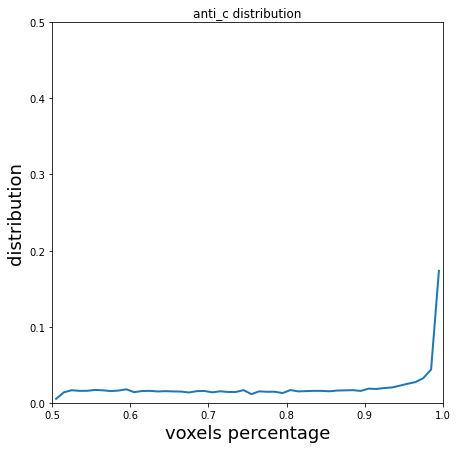

<Figure size 432x288 with 0 Axes>

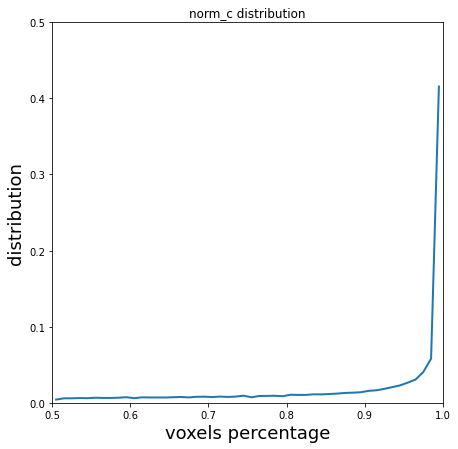

In [10]:
    # voxels information in anti-c GBs --- Yes I think it can be confidence!!!!!!
    bin_interval = 0.01
    x_lim = [0.5,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    Antic_voxel_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    antic_voxel_num_bin = np.zeros(bin_number)
    normc_voxel_num_bin = np.zeros(bin_number)
    for index in range(len(GB_antic_list_dV_normD_list)):
        antic_voxel_num_bin[int((GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    for index in range(len(GB_normc_list_dV_normD_list)):
        normc_voxel_num_bin[int((GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    # plot
    figure_name_all_bin = f"figures/3D_antic_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("anti_c distribution")
    plt.plot(Antic_voxel_coordinate, antic_voxel_num_bin/np.sum(antic_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    figure_name_all_bin = f"figures/3D_normc_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("norm_c distribution")
    plt.plot(Antic_voxel_coordinate, normc_voxel_num_bin/np.sum(normc_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
        
    confidence_factor = 0.99
    
    update_GB_antic_list_velocity_AllList = []
    update_GB_antic_list_curvature_AllList = []
    update_GB_antic_list_GBenergy_AllList = []
    update_GB_antic_list_anticNum_AllList = []
    update_GB_antic_list_area_AllList = []
    update_GB_antic_list_dV_normD_AllList = []
    update_GB_antic_list_dV_antiD_AllList = []
    
    update_GB_antic_list_velocity_list = []
    update_GB_antic_list_curvature_list = []
    update_GB_antic_list_GBenergy_list = []
    update_GB_antic_list_anticNum_list = []
    update_GB_antic_list_area_list = []
    update_GB_antic_list_dV_normD_list = []
    update_GB_antic_list_dV_antiD_list = []
    for index in range(len(GB_antic_list_velocity_list)):
        if GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_antic_list_velocity_list.append(GB_antic_list_velocity_list[index])
            update_GB_antic_list_curvature_list.append(GB_antic_list_curvature_list[index])
            update_GB_antic_list_GBenergy_list.append(GB_antic_list_GBenergy_list[index])
            update_GB_antic_list_anticNum_list.append(GB_antic_list_anticNum_list[index])
            update_GB_antic_list_area_list.append(GB_antic_list_area_list[index])
            update_GB_antic_list_dV_normD_list.append(GB_antic_list_dV_normD_list[index])
            update_GB_antic_list_dV_antiD_list.append(GB_antic_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_antic_list_velocity_AllList)):
        tmp_update_GB_antic_list_velocity_AllList =[]
        tmp_update_GB_antic_list_curvature_AllList =[]
        tmp_update_GB_antic_list_GBenergy_AllList = []
        tmp_update_GB_antic_list_anticNum_AllList = []
        tmp_update_GB_antic_list_area_AllList = []
        tmp_update_GB_antic_list_dV_normD_AllList = []
        tmp_update_GB_antic_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_antic_list_velocity_AllList[index_i])):
            if GB_antic_list_dV_antiD_AllList[index_i][index_j]/(GB_antic_list_dV_normD_AllList[index_i][index_j]+GB_antic_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_antic_list_velocity_AllList.append(GB_antic_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_antic_list_curvature_AllList.append(GB_antic_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_antic_list_GBenergy_AllList.append(GB_antic_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_antic_list_anticNum_AllList.append(GB_antic_list_anticNum_AllList[index_i][index_j])
                tmp_update_GB_antic_list_area_AllList.append(GB_antic_list_area_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_normD_AllList.append(GB_antic_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_antiD_AllList.append(GB_antic_list_dV_antiD_AllList[index_i][index_j])
        update_GB_antic_list_velocity_AllList.append(tmp_update_GB_antic_list_velocity_AllList)
        update_GB_antic_list_curvature_AllList.append(tmp_update_GB_antic_list_curvature_AllList)
        update_GB_antic_list_GBenergy_AllList.append(tmp_update_GB_antic_list_GBenergy_AllList)
        update_GB_antic_list_anticNum_AllList.append(tmp_update_GB_antic_list_anticNum_AllList)
        update_GB_antic_list_area_AllList.append(tmp_update_GB_antic_list_area_AllList)
        update_GB_antic_list_dV_normD_AllList.append(tmp_update_GB_antic_list_dV_normD_AllList)
        update_GB_antic_list_dV_antiD_AllList.append(tmp_update_GB_antic_list_dV_antiD_AllList)
        
        
    update_GB_normc_list_velocity_AllList = []
    update_GB_normc_list_curvature_AllList = []
    update_GB_normc_list_GBenergy_AllList = []
    update_GB_normc_list_area_AllList = []
    update_GB_normc_list_dV_normD_AllList = []
    update_GB_normc_list_dV_antiD_AllList = []
    
    update_GB_normc_list_velocity_list = []
    update_GB_normc_list_curvature_list = []
    update_GB_normc_list_GBenergy_list = []
    update_GB_normc_list_area_list = []
    update_GB_normc_list_dV_normD_list = []
    update_GB_normc_list_dV_antiD_list = []
    for index in range(len(GB_normc_list_velocity_list)):
        if GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_normc_list_velocity_list.append(GB_normc_list_velocity_list[index])
            update_GB_normc_list_curvature_list.append(GB_normc_list_curvature_list[index])
            update_GB_normc_list_GBenergy_list.append(GB_normc_list_GBenergy_list[index])
            update_GB_normc_list_area_list.append(GB_normc_list_area_list[index])
            update_GB_normc_list_dV_normD_list.append(GB_normc_list_dV_normD_list[index])
            update_GB_normc_list_dV_antiD_list.append(GB_normc_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_normc_list_velocity_AllList)):
        tmp_update_GB_normc_list_velocity_AllList =[]
        tmp_update_GB_normc_list_curvature_AllList =[]
        tmp_update_GB_normc_list_GBenergy_AllList = []
        tmp_update_GB_normc_list_area_AllList = []
        tmp_update_GB_normc_list_dV_normD_AllList = []
        tmp_update_GB_normc_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_normc_list_velocity_AllList[index_i])):
            if GB_normc_list_dV_normD_AllList[index_i][index_j]/(GB_normc_list_dV_normD_AllList[index_i][index_j]+GB_normc_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_normc_list_velocity_AllList.append(GB_normc_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_normc_list_curvature_AllList.append(GB_normc_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_normc_list_GBenergy_AllList.append(GB_normc_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_normc_list_area_AllList.append(GB_normc_list_area_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_normD_AllList.append(GB_normc_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_antiD_AllList.append(GB_normc_list_dV_antiD_AllList[index_i][index_j])
        update_GB_normc_list_velocity_AllList.append(tmp_update_GB_normc_list_velocity_AllList)
        update_GB_normc_list_curvature_AllList.append(tmp_update_GB_normc_list_curvature_AllList)
        update_GB_normc_list_GBenergy_AllList.append(tmp_update_GB_normc_list_GBenergy_AllList)
        update_GB_normc_list_area_AllList.append(tmp_update_GB_normc_list_area_AllList)
        update_GB_normc_list_dV_normD_AllList.append(tmp_update_GB_normc_list_dV_normD_AllList)
        update_GB_normc_list_dV_antiD_AllList.append(tmp_update_GB_normc_list_dV_antiD_AllList)
        
            
    

In [11]:
    print("Voxels on anti-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_antic_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of norm-curvature voxels during whole simulations is {normal_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()

    print("anti-c GB before removing low fraction")
    total_GB_num = 0
    for time_step in range(3,step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_dV_normD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(GB_antic_list_dV_normD_list)/total_GB_num_real*100}% and {len(GB_normc_list_dV_normD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("anti-c GB after removing low fraction")

    # number of GB woth high anti-c fraction (99%)
    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(update_GB_antic_list_dV_antiD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(update_GB_antic_list_dV_antiD_list)/total_GB_num_real*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) {len(update_GB_antic_list_dV_antiD_list)/total_GB_num*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 4311 and 2860998
The ratio of anti-curvature voxels during whole simulations is 99.84954502289281% in 2865309 voxels

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 58031311 and 75917
The ratio of norm-curvature voxels during whole simulations is 99.86935016070633% in 58107228 voxels

anti-c GB before removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 98898
The ratio of anti-curvature and norm GBs during whole simulations is 19.59994688683527% and 80.40005311316473% in 504583 GBs

anti-c GB after removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 17149
The ratio of anti-curvature and norm GBs during whole simulations is 3.3986479925007385% and 33.41254065238029% in 504583 GBs

The ratio of anti-curvature and norm GBs during whole simulations is (origi

99.59570576099472% GBs with curvature smaller than 0.2
4.6286136831451605
all points fitting: 0.10338574708335935
all points slope: -1.0892823290002351
smaller points fitting: 0.9949976986767908
smaller points slope: 7.194292137323718


<Figure size 432x288 with 0 Axes>

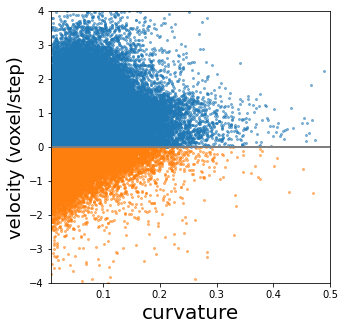

<Figure size 432x288 with 0 Axes>

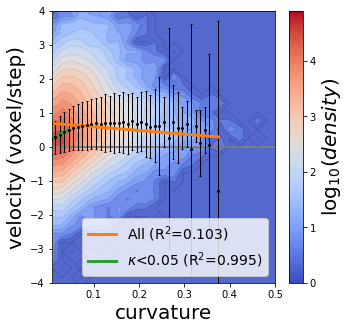

In [12]:
    # All in 1 figrue
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(GB_normc_list_curvature_list, GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.8, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-5.0, 5.0, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(GB_normc_list_curvature_list+GB_antic_list_curvature_list, GB_normc_list_velocity_list+GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # bin plot
    bin_interval = 0.01
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    curvature_bin_counts = np.zeros(bin_number)
    velocity_bin_sums = np.zeros(bin_number)
    velocity_bin_squared_sums = np.zeros(bin_number)

    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    print(f"{np.sum(np.array(new_curvature_1Dlist_remove_0step)<0.2)/len(new_curvature_1Dlist_remove_0step)*100}% GBs with curvature smaller than 0.2")
    new_velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list

    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        if abs(curvature_val) > x_lim[1]:
            continue
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        curvature_bin_counts[bin_idx] += 1
        velocity_bin_sums[bin_idx] += velocity_val
        velocity_bin_squared_sums[bin_idx] += velocity_val ** 2

    velocity_bin_means = np.zeros(bin_number)
    velocity_bin_stds = np.zeros(bin_number)

    for i in range(bin_number):
        if curvature_bin_counts[i] > 0:
            velocity_bin_means[i] = velocity_bin_sums[i] / curvature_bin_counts[i]
            velocity_bin_stds[i] = np.sqrt((velocity_bin_squared_sums[i] / curvature_bin_counts[i]) - velocity_bin_means[i]**2)

    
    
    figure_name_all = f"figures/3D_velocity_signedcurvature_hotUpdate_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 1
    print(np.max(np.log10(hist.T)))
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1,vmin=0,vmax=4.9)
    plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=0,vmax=4.9)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=0,vmax=4.9))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(density)$", fontsize=20)
    
    # plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o-', c='k', linewidth=1)
    valid_bins = curvature_bin_counts > 10
    plt.errorbar(curvature_coordinate[valid_bins], velocity_bin_means[valid_bins], yerr=velocity_bin_stds[valid_bins],
             fmt='o', color='k', linewidth=1, capsize=1, ecolor='black', markersize=2)
    
    # Linear fit for all valid bins
    x_all = curvature_coordinate[valid_bins]
    y_all = velocity_bin_means[valid_bins]
    p_all = np.polyfit(x_all, y_all, 1)
    y_pred_all = np.polyval(p_all, x_all)
    r2_all = 1 - np.sum((y_all - y_pred_all)**2) / np.sum((y_all - np.mean(y_all))**2)
    print(f"all points fitting: {r2_all}")
    print(f"all points slope: {p_all[0]}")
    
    # Linear fit for valid bins with curvature < 0.05
    mask_sub = x_all < 0.05
    x_sub = x_all[mask_sub]
    y_sub = y_all[mask_sub]
    if len(x_sub) > 1:
        p_sub = np.polyfit(x_sub, y_sub, 1)
        y_pred_sub = np.polyval(p_sub, x_sub)
        r2_sub = 1 - np.sum((y_sub - y_pred_sub)**2) / np.sum((y_sub - np.mean(y_sub))**2)
    else:
        r2_sub = np.nan
    print(f"smaller points fitting: {r2_sub}")
    print(f"smaller points slope: {p_sub[0]}")
    
    # Plot linear fits
    plt.plot(x_all, y_pred_all, '-', color='C1', linewidth=3, label=rf'All (R$^2$={r2_all:.3f})')
    if len(x_sub) > 1:
        plt.plot(x_sub, y_pred_sub, '-', color='C2', linewidth=3, label=rf'$\kappa$<0.05 (R$^2$={r2_sub:.3f})')
    plt.legend(loc='lower right', fontsize=14)
    
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    


Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

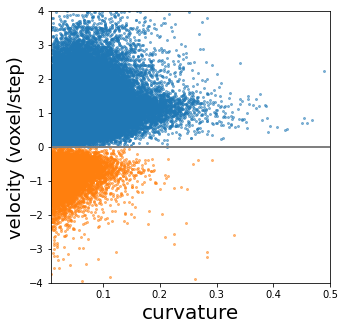

<Figure size 432x288 with 0 Axes>

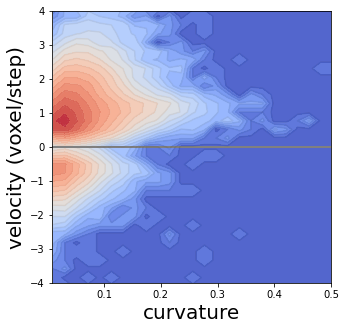

<Figure size 432x288 with 0 Axes>

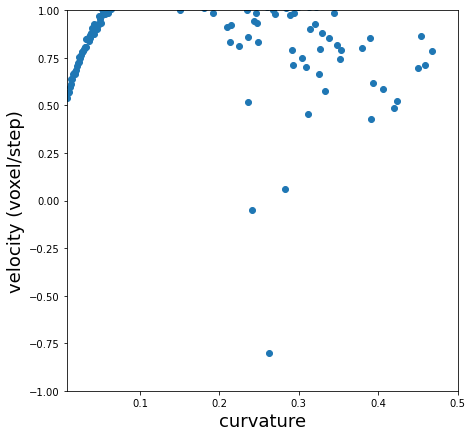

In [13]:
    # All in 1 figrue
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(update_GB_normc_list_curvature_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(update_GB_antic_list_curvature_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.8, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-5.0, 5.0, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(update_GB_normc_list_curvature_list+update_GB_antic_list_curvature_list, update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/3D_velocity_signedcurvature_confi_hotUpdate_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contourf(X, Y, np.log(hist.T), levels=20, cmap='coolwarm', alpha=0.9)
    plt.contour(X, Y, np.log(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    new_curvature_1Dlist_remove_0step = update_GB_normc_list_curvature_list + update_GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list + update_GB_antic_list_velocity_list
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        if abs(new_curvature_1Dlist_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


1.4012641079977237


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

/apps/python/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


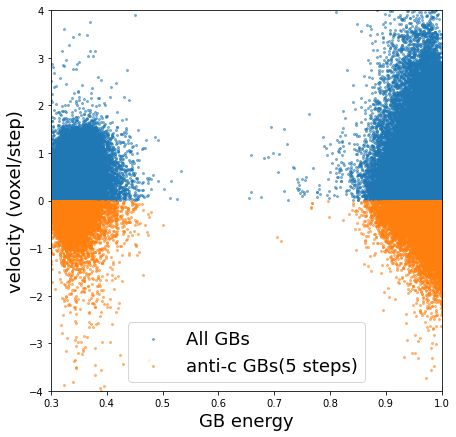

<Figure size 432x288 with 0 Axes>

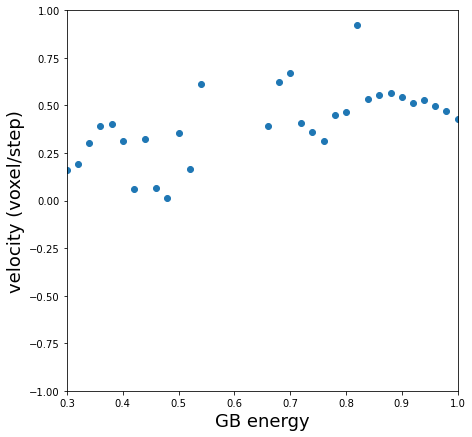

<Figure size 432x288 with 0 Axes>

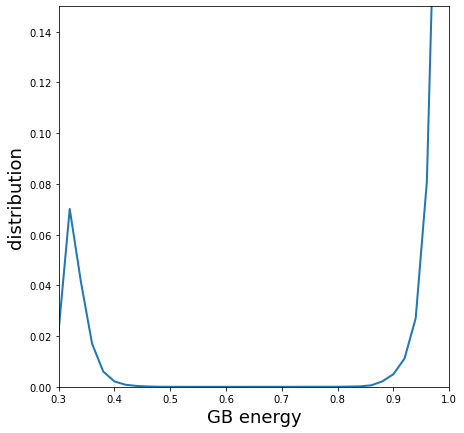

<Figure size 432x288 with 0 Axes>

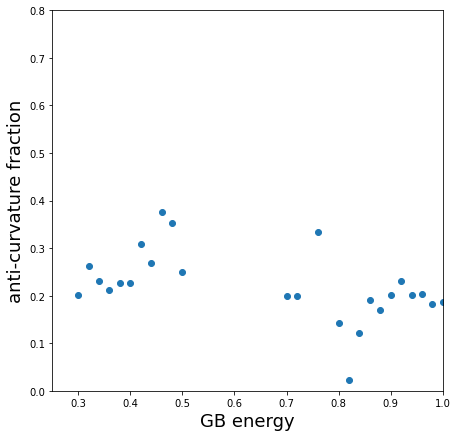

<Figure size 432x288 with 0 Axes>

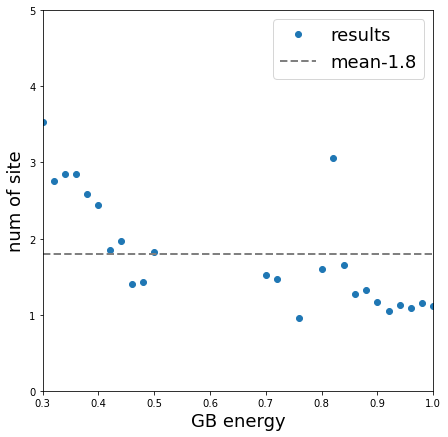

In [14]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GB_normc_list_GBenergy_list, GB_normc_list_velocity_list,s=4,alpha=0.5,label='All GBs')
    plt.scatter(GB_antic_list_GBenergy_list, GB_antic_list_velocity_list,s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.02
    x_lim = [0.25,1.01]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list+GB_antic_list_GBenergy_list
    velocity_1Dlist_remove_0step = GB_normc_list_velocity_list+GB_antic_list_velocity_list
    for index in range(len(GBenergy_1Dlist_remove_0step)):
        if abs(GBenergy_1Dlist_remove_0step[index])>=x_lim[1] or abs(GBenergy_1Dlist_remove_0step[index])<=x_lim[0]: continue
        GBenergy_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_remove_0step[index])
    for index in range(len(GB_antic_list_GBenergy_list)):
        if abs(GB_antic_list_GBenergy_list[index])>=x_lim[1] or abs(GB_antic_list_GBenergy_list[index])<=x_lim[0]: continue
        antic_num_bin[int((GB_antic_list_GBenergy_list[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.25,1.0])
    plt.ylim([0,0.8])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


1.7233384835566241


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

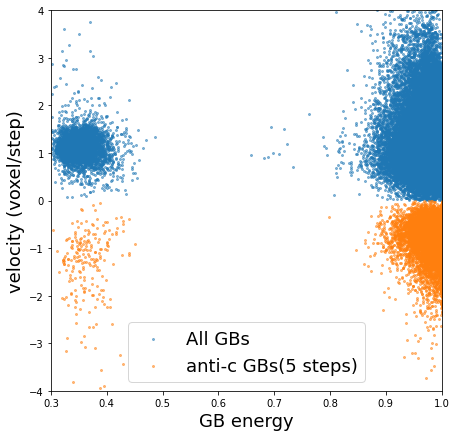

<Figure size 432x288 with 0 Axes>

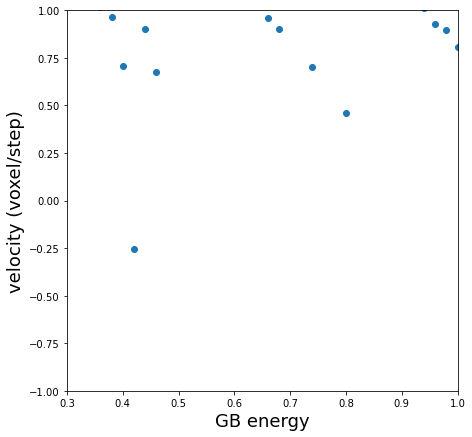

<Figure size 432x288 with 0 Axes>

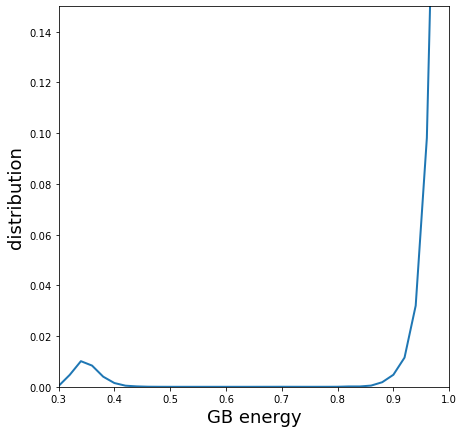

<Figure size 432x288 with 0 Axes>

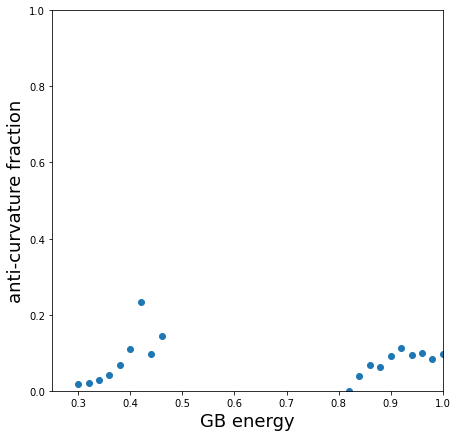

<Figure size 432x288 with 0 Axes>

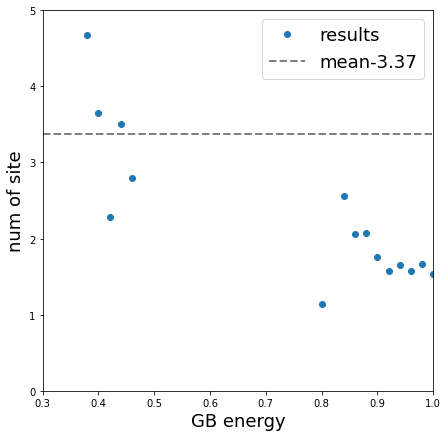

In [15]:

    figure_name_all = f"figures/3D_velocity_GBenergy_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_1Dlist_remove_0step, velocity_1Dlist_remove_0step,s=4,alpha=0.5,label='All GBs')
    # GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    # GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    # GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    # plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.scatter(update_GB_normc_list_GBenergy_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5,label='All GBs')
    plt.scatter(update_GB_antic_list_GBenergy_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.02
    x_lim = [0.25,1.01]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    new_GBenergy_1Dlist_remove_0step = update_GB_normc_list_GBenergy_list+update_GB_antic_list_GBenergy_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        if abs(new_GBenergy_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_GBenergy_1Dlist_remove_0step[index])<=x_lim[0]: continue
        GBenergy_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
        # if new_velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(new_GBenergy_1Dlist_remove_0step[index])
    for index in range(len(update_GB_antic_list_GBenergy_list)):
        if abs(update_GB_antic_list_GBenergy_list[index])>=x_lim[1] or abs(update_GB_antic_list_GBenergy_list[index])<=x_lim[0]: continue
        antic_num_bin[int((update_GB_antic_list_GBenergy_list[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.25,1.0])
    plt.ylim([0,1.0])
    plt.plot(GBenergy_coordinate[GBenergy_bin>5], antic_ratio_bin[GBenergy_bin>5],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_confi_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


In [16]:
GBenergy_bin

array([0.00000e+00, 0.00000e+00, 5.90000e+01, 8.73000e+02, 1.87500e+03,
       1.55200e+03, 7.40000e+02, 2.75000e+02, 8.10000e+01, 3.10000e+01,
       7.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       1.00000e+00, 2.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00,
       1.00000e+00, 2.00000e+00, 4.00000e+00, 2.60000e+01, 2.60000e+01,
       8.80000e+01, 3.35000e+02, 8.80000e+02, 2.13800e+03, 5.93600e+03,
       1.82120e+04, 5.18640e+04, 1.00612e+05])

Text(0.5, 1.0, 'step: 46')

<Figure size 432x288 with 0 Axes>

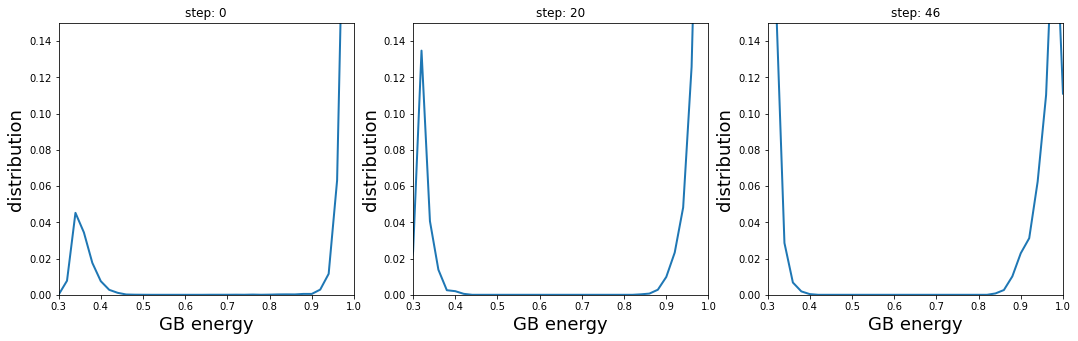

In [17]:
    # distribution for init and end
    plt.figure()
    fig = plt.figure(figsize=(18, 5))
    dis_step = 0
    GBenergy_bin = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[dis_step])):
        if abs(GB_list_GBenergy_list[dis_step][index])>=1.0: continue
        GBenergy_bin[int((GB_list_GBenergy_list[dis_step][index]-x_lim[0])//bin_interval)] += 1
    plt.subplot(131)
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.title(f"step: {dis_step}")
    
    dis_step = 20
    GBenergy_bin = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[dis_step])):
        if abs(GB_list_GBenergy_list[dis_step][index])>=1.0: continue
        GBenergy_bin[int((GB_list_GBenergy_list[dis_step][index]-x_lim[0])//bin_interval)] += 1
    plt.subplot(132)
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.title(f"step: {dis_step}")
    
    dis_step = -1
    GBenergy_bin = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[dis_step])):
        if abs(GB_list_GBenergy_list[dis_step][index])>=1.0: continue
        GBenergy_bin[int((GB_list_GBenergy_list[dis_step][index]-x_lim[0])//bin_interval)] += 1
    plt.subplot(133)
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.title(f"step: {len(GB_list_GBenergy_list)-1}")

<Figure size 432x288 with 0 Axes>

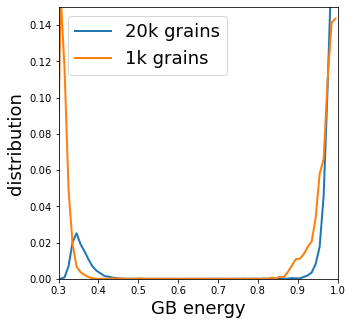

<Figure size 432x288 with 0 Axes>

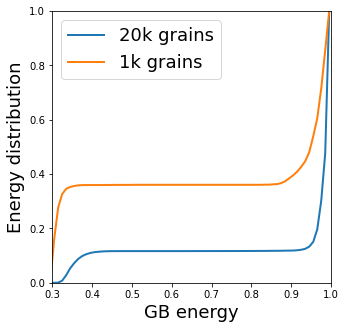

In [18]:
    # distribution for init and end
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    figure_name_distri = f"figures/3D_one_step_distribution_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = step_1000grains
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>=1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>=1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin_first/np.sum(GBenergy_bin_first),'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, GBenergy_bin_second/np.sum(GBenergy_bin_second),'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')
    
    # distribution for init and end
    figure_name_distri = f"figures/3D_culmmulative_distribution_function_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = step_1000grains
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>=1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_first = GBenergy_bin_first/np.sum(GBenergy_bin_first)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>=1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = GBenergy_bin_second/np.sum(GBenergy_bin_second)
    culmmulative_GBenergy_bin_first = np.zeros(bin_number) 
    culmmulative_GBenergy_bin_second = np.zeros(bin_number) 
    for i in range(bin_number):
        culmmulative_GBenergy_bin_first[i] = np.sum(GBenergy_bin_first[:i+1])
        culmmulative_GBenergy_bin_second[i] = np.sum(GBenergy_bin_second[:i+1])
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.0])
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_first,'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_second,'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("Energy distribution", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')


Text(0, 0.5, 'curvature fraction')

<Figure size 432x288 with 0 Axes>

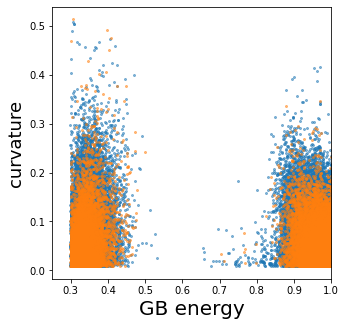

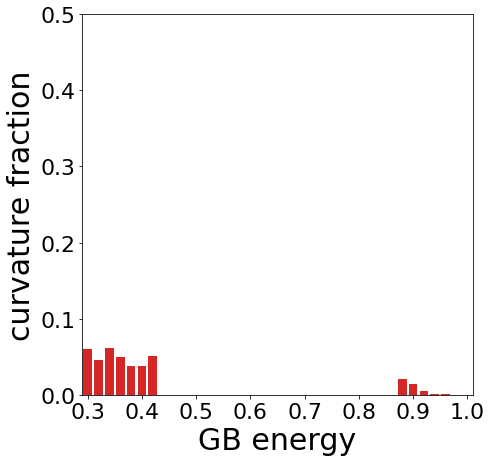

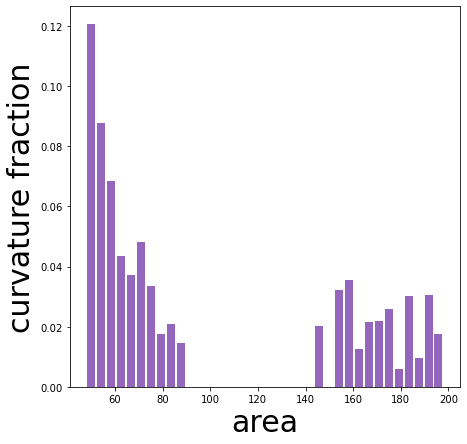

In [19]:
    # curvature VS GB energy
            
    figure_name_all = f"figures/3D_signedcurvature_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    # plt.plot([0.3,1.0],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(GB_normc_list_GBenergy_list, GB_normc_list_curvature_list, s=4,alpha=0.5)
    plt.scatter(GB_antic_list_GBenergy_list, GB_antic_list_curvature_list, s=4,alpha=0.5,color='C01')
    plt.xlabel("GB energy", fontsize=20)
    plt.ylabel("curvature", fontsize=18)
    plt.xlim([0.25,1.0])
    # plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot signedcurvature VS GBenergy
    bin_interval = 0.02
    x_lim = [0.29,1.01] # GB energy
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval) + bin_interval/2
    y_lim = [50,200] # area
    y_bin_interval = (y_lim[1]-y_lim[0])/bin_number
    area_coordinate = np.arange(y_lim[0],y_lim[1],y_bin_interval) + bin_interval/2

    curvature_bin = np.zeros(bin_number)
    curvature_fraction_energy_bin = np.zeros(bin_number)
    curvature_fraction_area_bin = np.zeros(bin_number)
    curvature_fraction_matrix = np.zeros((bin_number,bin_number))
    GBenergy_distribution_bin = np.zeros(bin_number)
    area_distribution_bin = np.zeros(bin_number)
    distribution_matrix_bin = np.zeros((bin_number,bin_number))
    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    new_GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list + GB_antic_list_GBenergy_list
    new_area_1Dlist_remove_0step = GB_normc_list_area_list + GB_antic_list_area_list
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        # prefactor: avoid GB energy larger 1 and get coordinate index
        if abs(new_GBenergy_1Dlist_remove_0step[index]) >= x_lim[1] or abs(new_GBenergy_1Dlist_remove_0step[index]) <= x_lim[0]: continue
        if abs(new_area_1Dlist_remove_0step[index]) >= y_lim[1] or abs(new_area_1Dlist_remove_0step[index]) <= y_lim[0]: continue
        GB_energy_index = int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)
        area_index = int((new_area_1Dlist_remove_0step[index]-y_lim[0])//y_bin_interval)
        # distribution
        GBenergy_distribution_bin[GB_energy_index] += 1
        area_distribution_bin[area_index] += 1
        distribution_matrix_bin[GB_energy_index,area_index] += 1
        # averaged curvature
        curvature_bin[GB_energy_index] += new_curvature_1Dlist_remove_0step[index]
        # calculate high curvature fraction vs GB energy or vs energy-area matrix
        if new_curvature_1Dlist_remove_0step[index] > 0.23:
            curvature_fraction_energy_bin[GB_energy_index] += 1  # calculate high curvature fraction vs GB energy
            curvature_fraction_area_bin[area_index] += 1  # calculate high curvature fraction vs area
            curvature_fraction_matrix[GB_energy_index,area_index] += 1 # calculate high curvature fraction vs energy-area matrix
    # normalized
    curvature_bin[GBenergy_distribution_bin>0] /= GBenergy_distribution_bin[GBenergy_distribution_bin>0]
    curvature_fraction_energy_bin[GBenergy_distribution_bin>0] /= GBenergy_distribution_bin[GBenergy_distribution_bin>0]
    curvature_fraction_energy_bin /= np.sum(curvature_fraction_energy_bin)
    curvature_fraction_area_bin[area_distribution_bin>0] /= area_distribution_bin[area_distribution_bin>0]
    curvature_fraction_area_bin /= np.sum(curvature_fraction_area_bin)
    curvature_fraction_matrix[distribution_matrix_bin>0] /= distribution_matrix_bin[distribution_matrix_bin>0]
    curvature_fraction_matrix /= np.sum(curvature_fraction_matrix)
    
    figure_name_all_bin = f"figures/3D_signedcurvature_GBenergy_{case_name}_5d_afterBin.png"
    fig = plt.figure(figsize=(7, 7))
    plt.xlim(x_lim)
    plt.ylim([0,0.5])
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    mask_frequency = GBenergy_distribution_bin/np.sum(GBenergy_distribution_bin)>1e-3
    plt.bar(GBenergy_coordinate[mask_frequency], curvature_fraction_energy_bin[mask_frequency], width=bin_interval*0.8, color=f'C3', label='MI_cos')
    # plt.plot(GBenergy_coordinate, velocity_bin,'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=30)
    plt.ylabel("curvature fraction", fontsize=30)
    # plt.legend(fontsize=30)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    fig = plt.figure(figsize=(7, 7))
    # plt.xlim(x_lim)
    # plt.ylim([0,0.11])
    plt.bar(area_coordinate[GBenergy_distribution_bin>5], curvature_fraction_area_bin[GBenergy_distribution_bin>5], width=y_bin_interval*0.8, color=f'C4', label='MI_cos')
    # plt.plot(area_coordinate, curvature_fraction_area_bin, linewidth=2)
    plt.xlabel("area", fontsize=30)
    plt.ylabel("curvature fraction", fontsize=30)


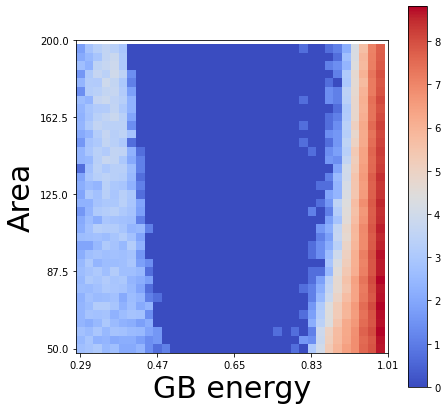

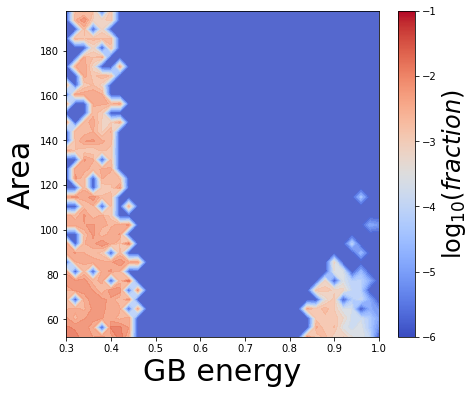

In [20]:
    # matrix distribution
    fig = plt.figure(figsize=(7,7))
    distribution_matrix_bin[distribution_matrix_bin==0]=1
    plt.imshow(np.log(distribution_matrix_bin.T),cmap='coolwarm')
    plt.xlabel("GB energy", fontsize=30)
    plt.ylabel("Area", fontsize=30)
    cbar = plt.colorbar()
    plt.xticks(np.linspace(0,bin_number,5),np.round(np.linspace(x_lim[0],x_lim[1],5),2))
    plt.yticks(np.linspace(0,bin_number,5),np.round(np.linspace(y_lim[0],y_lim[1],5),2))
    plt.gca().invert_yaxis()
    
    
    x_bins = np.linspace( x_lim[0], x_lim[1], bin_number+1)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace( y_lim[0], y_lim[1], bin_number+1)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(new_GBenergy_1Dlist_remove_0step, new_area_1Dlist_remove_0step, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    
    figure_name_all = f"figures/3D_GBenergy_area_hotUpdate_{case_name}_5d.png"
    fig = plt.figure(figsize=(7,6))
    # curvature_fraction_matrix[curvature_fraction_matrix==0]=1
    # plt.imshow(curvature_fraction_matrix.T,cmap='coolwarm',vmax=0.01)
    curvature_fraction_matrix[curvature_fraction_matrix==0]=1e-6
    curvature_fraction_matrix[distribution_matrix_bin<=5]=1e-6
    plt.contourf(X, Y, np.log10(curvature_fraction_matrix.T), levels=20, cmap='coolwarm', alpha=0.9, vmin=-6,vmax=-1)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=-6,vmax=-1))
    cbar = plt.colorbar(sm)
    plt.xlabel("GB energy", fontsize=30)
    plt.ylabel("Area", fontsize=30)
    cbar.set_label(u"$\log_{10}(fraction)$", fontsize=24)
    # plt.xlim([50,5000])
    # plt.ylim([-5.0,5.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    

## For one time step

In [20]:
 
    expected_grain_num = 5000
    
    # get corresponding step
    grain_num_array = np.zeros(npy_file_aniso.shape[0])
    for time_step in tqdm(range(npy_file_aniso.shape[0])):
        # Calculate the number of grains
        unique_id_num = len(np.unique(npy_file_aniso[time_step,:]))
        grain_num_array[time_step] = unique_id_num
        if unique_id_num < expected_grain_num*0.9: break # jump out of the loop if the id is too less
    expected_step = int(np.argmin(abs(grain_num_array - expected_grain_num)))
    

 18%|█▊        | 14/76 [00:36<02:40,  2.59s/it]


In [21]:
    # fraction
    total_GB_num_1step = len(GB_infomation_dict_list[expected_step].keys())
    anti_c_num_1step = 0
    for key in GB_id_focus_detail:
        if expected_step in GB_id_focus_detail[key]: anti_c_num_1step += 1
    print(f"Anti-curvature GBs at step {expected_step} with {expected_grain_num} grains is {anti_c_num_1step}")
    print(f"Anti-curvature fraction at step {expected_step} with {expected_grain_num} grains is {anti_c_num_1step/total_GB_num_1step*100}% in {total_GB_num_1step} GBs")



Anti-curvature GBs at step 12 with 5000 grains is 12144
Anti-curvature fraction at step 12 with 5000 grains is 33.053892215568865% in 36740 GBs


<Figure size 432x288 with 0 Axes>

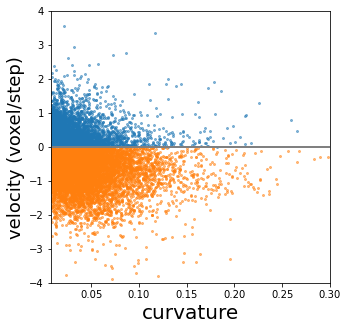

<Figure size 432x288 with 0 Axes>

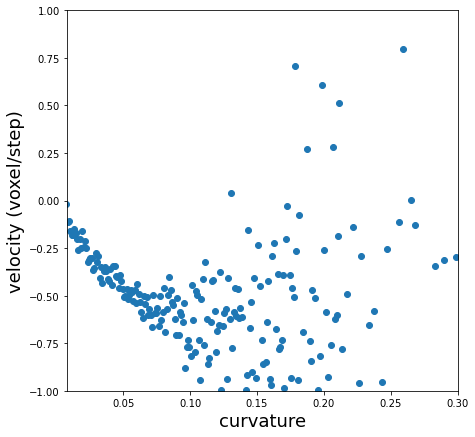

In [22]:
    # All in 1 figrue
    curvature_1Dlist_1step = GB_list_curvature_list[expected_step]
    velocity_1Dlist_1step = GB_list_velocity_list[expected_step]
    GBenergy_1Dlist_1step = GB_list_GBenergy_list[expected_step]
    GB_antic_list_curvature_1step = GB_antic_list_curvature_AllList[expected_step]
    GB_antic_list_velocity_1step = GB_antic_list_velocity_AllList[expected_step]
    GB_antic_list_GBenergy_1step = GB_antic_list_GBenergy_AllList[expected_step]
    GB_antic_list_anticNum_1step = GB_antic_list_anticNum_AllList[expected_step]
    
    # ignore the sign of curvature for all GBs list
    for i in range(len(curvature_1Dlist_1step)):
        if curvature_1Dlist_1step[i]<0: 
            curvature_1Dlist_1step[i] = - curvature_1Dlist_1step[i]
            velocity_1Dlist_1step[i] = - velocity_1Dlist_1step[i]
    velocity_1Dlist_1step = np.array(velocity_1Dlist_1step)
    curvature_1Dlist_1step = np.array(curvature_1Dlist_1step)
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.3],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_1step[velocity_1Dlist_1step>0], velocity_1Dlist_1step[velocity_1Dlist_1step>0],s=4,alpha=0.5)
    # plt.scatter(curvature_1Dlist_1step[velocity_1Dlist_1step<0], velocity_1Dlist_1step[velocity_1Dlist_1step<0],s=4,alpha=0.5,color='C01')
    plt.scatter(GB_antic_list_curvature_1step, GB_antic_list_velocity_1step,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.3]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_1step)):
        if abs(curvature_1Dlist_1step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_1step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_1step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


0.2885171137383652


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

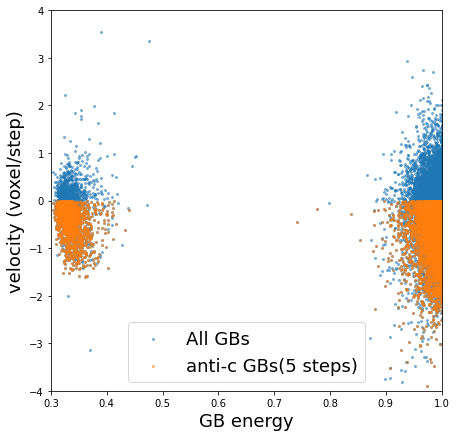

<Figure size 432x288 with 0 Axes>

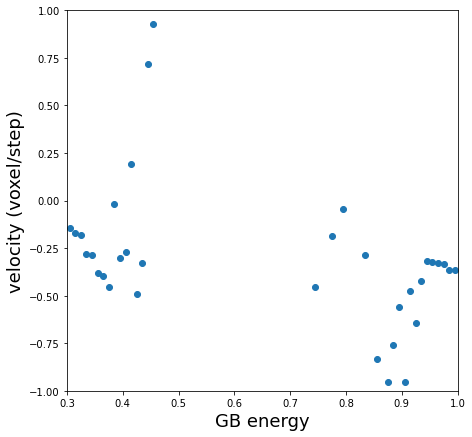

<Figure size 432x288 with 0 Axes>

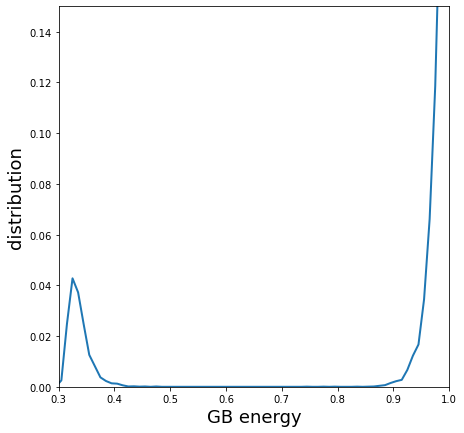

<Figure size 432x288 with 0 Axes>

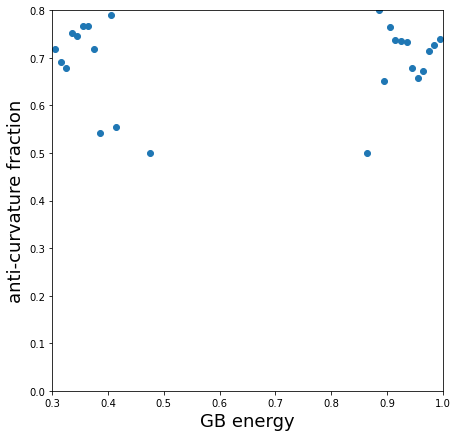

<Figure size 432x288 with 0 Axes>

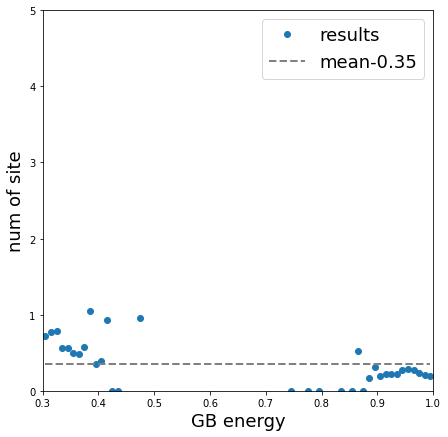

In [23]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_1step, velocity_1Dlist_1step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_1step = np.array(GB_antic_list_GBenergy_1step)
    GB_antic_list_velocity_1step = np.array(GB_antic_list_velocity_1step)
    GB_antic_list_anticNum_1step = np.array(GB_antic_list_anticNum_1step)
    plt.scatter(GB_antic_list_GBenergy_1step[GB_antic_list_anticNum_1step>=5], GB_antic_list_velocity_1step[GB_antic_list_anticNum_1step>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_1step)):
        if abs(GBenergy_1Dlist_1step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_1step[index]
        if velocity_1Dlist_1step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_1step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.8])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}_{expected_grain_num}grains"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        
